In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#query to retreieve latest date
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#query to retrieve 12 months from lastest_date
original_date = dt.date(2018,1, 1) - dt.timedelta(days=365)

yearly_prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > original_date).\
                        order_by(Measurement.date).all()

In [11]:
# Perform a query to retrieve the data and prcp scores
prcp_df = pd.DataFrame(yearly_prcp, columns=['Date', 'Precipitation'])

# Change the date to a datetime format
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'], format='%Y/%m/%d')

#Get the total for each station for each date 
total_prcp = prcp_df.pivot_table(prcp_df, index=['Date'], aggfunc='mean')
total_prcp.head()

,Precipitation
Date,
2017-01-02,0.004000
2017-01-03,0.000000
2017-01-04,0.030000
2017-01-05,0.158333
2017-01-06,0.133333


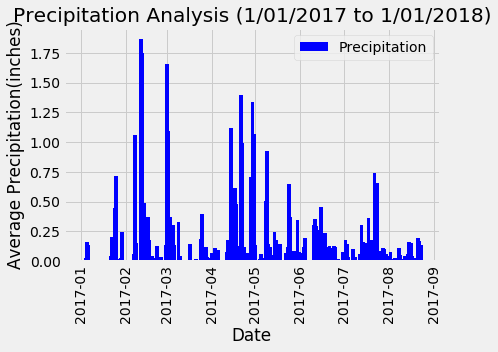

<Figure size 864x432 with 0 Axes>

In [12]:
# Plot the dataframe as a horizontal bar chart using pandas plotting
style.use('fivethirtyeight')

plt.bar(total_prcp.index, total_prcp["Precipitation"], width=2.5, color="blue")
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Date")
plt.ylabel("Average Precipitation(inches)")
plt.title("Precipitation Analysis (1/01/2017 to 1/01/2018)")
plt.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.show()
plt.savefig("Precipitation_Analysis.png")

In [13]:
#Summary of Stats
total_prcp.describe()

,Precipitation
count,234.000000
mean,0.156588
std,0.299172
min,0.000000
25%,0.005000
50%,0.047083
75%,0.152292
max,1.866667


In [14]:
#Find the total number of stations
total_stations = session.query(Station.station).count()
print("There are" + " " + str(total_stations) + " " + "stations in total.")

There are 9 stations in total.


In [15]:
# Query to find observation counts from most active stations in desc order
station_tobs = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc())

for station in station_tobs:
    print(station)
    
# Store station name
top_station = station_tobs[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
#Query to find station with highest observations
max_obs = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc()).first()
for station in max_obs:
    print(station)


USC00519281
2772


In [18]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
prev_temp = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > original_date).\
                    order_by(func.count(Measurement.tobs).desc()).all()

busiest_station = prev_temp[0][0:2]   

print("The stations with the highest number of observations(from highest to lowest) in the last 12 months are...")
print()
for station, name, count in prev_temp:
    print("The station",station, "in",name,"has",count, "observations.")

The stations with the highest number of observations(from highest to lowest) in the last 12 months are...

The station USC00519397 in WAIKIKI 717.2, HI US has 229 observations.
The station USC00516128 in MANOA LYON ARBO 785.2, HI US has 221 observations.
The station USC00519281 in WAIHEE 837.5, HI US has 220 observations.
The station USC00513117 in KANEOHE 838.1, HI US has 211 observations.
The station USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US has 209 observations.
The station USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US has 194 observations.
The station USC00517948 in PEARL CITY, HI US has 107 observations.


In [20]:
# Filter by the station with the highest number of observations.
highest_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station[0]).\
    filter(Measurement.date > original_date).\
    order_by(Measurement.date).all()

#create df. 
highest_obs_df = pd.DataFrame(highest_obs, columns=['Date', 'Tobs'])
highest_obs_df.head()

,Date,Tobs
0,2017-01-02,66.0
1,2017-01-03,63.0
2,2017-01-04,62.0
3,2017-01-05,63.0
4,2017-01-06,64.0


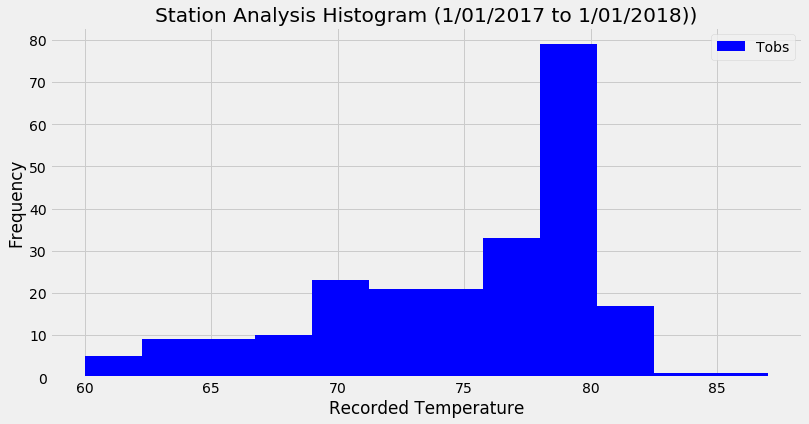

<Figure size 720x432 with 0 Axes>

In [21]:
#Plot station analysis histogram
plt.hist(highest_obs_df['Tobs'], bins=12, color = 'blue')
plt.rcParams['figure.figsize'] = [10,6]
plt.xlabel('Recorded Temperature')
plt.ylabel('Frequency')
plt.title("Station Analysis Histogram (1/01/2017 to 1/01/2018))")
plt.legend(['Tobs'])
plt.show()
plt.savefig("Station_Analysis.png")